# misc.

[...]

### LiteBIRD-like scanning strategy

[...]

We import all the libraries and packages we need.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('magma')
new_cmap = truncate_colormap(cmap, 0.2, 1)

[...]

We generate I, Q and U input maps from random angular power spectra.

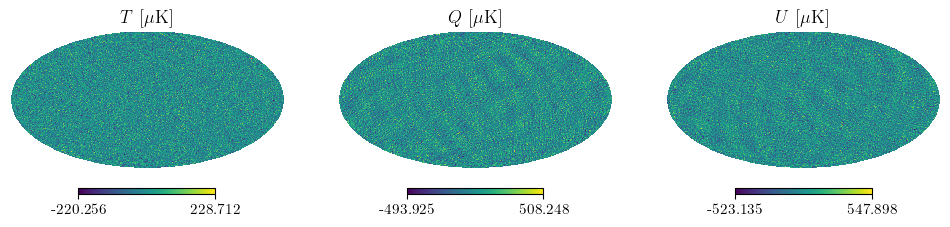

In [2]:
nside = 128
lmax = 2*nside

# generate input alm and maps
np.random.seed(10)
cls = np.random.rand(6,lmax)
cls[:,:2] *= 0
slm = hp.synalm(cls, lmax=lmax)
maps = hp.alm2map(slm,nside=nside)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

We initialize a single Gaussian beam with 5' FWHM.

In [3]:
fwhm_arcmin = 5
single_beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)

We specify the scanning strategy by directly providing the pointings.

In [4]:
ctime0 = 1510000000                   # initial time

duration = 3600*24*5                  # mission duration in s (5 days)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

ptg = np.empty((nsamp,3))             # initializing pointings array
ptg[:,0]=np.arange(nsamp)*1.5e-2      # theta
ptg[:,1]=np.arange(nsamp)*1.1e-2        # phi
ptg[:,2]=np.arange(nsamp)*np.pi*1e-2  # psi

t_samp_array = np.arange(nsamp)/fsamp # 

We run beamconv (scan_instrument_mpi) with those specifics and plot the hitmap.

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-8251200


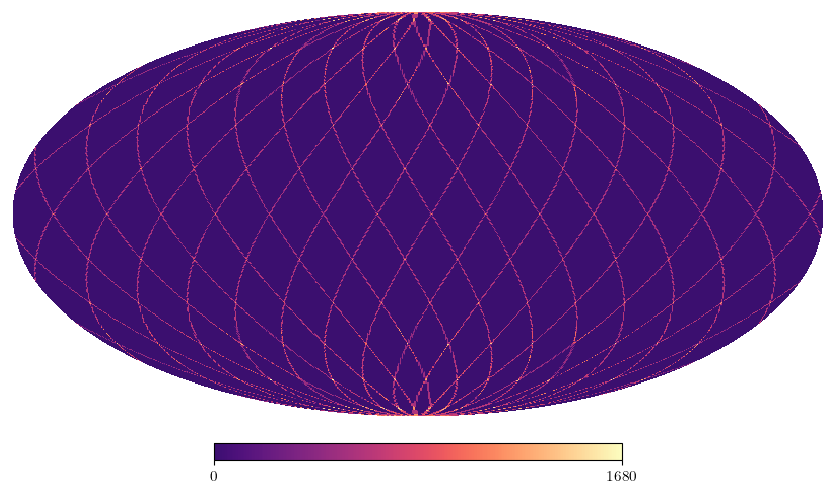

In [5]:
# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
psi = np.degrees(ptg[:,2])

# calculate the quaternion
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def ctime_test(**kwargs):
    return ctime0 + t_samp_array[kwargs.pop('start'):kwargs.pop('end')]

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.add_to_focal_plane(single_beam, combine=False)
S_ptg.allocate_maps(nside=nside)
S_ptg.scan_instrument_mpi(slm, save_tod=True, ctime_func=ctime_test, 
                          q_bore_func=q_bore_test, ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.savefig('proj_ptg.pdf')

del(S_ptg, cond, proj)

We re-run beamconv (scan_instrument_mpi) with a LiteBIRD-like scanning strategy by setting use_l2_scan=True.

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-8251200
Implementing L2 scan


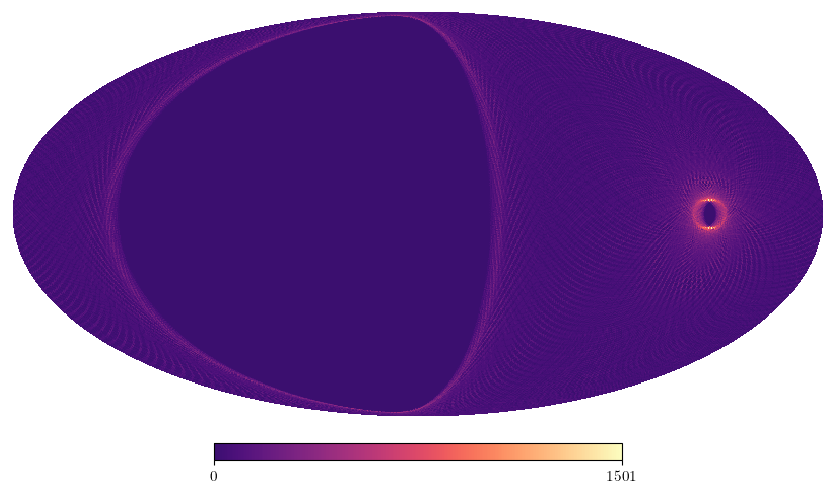

In [6]:
S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp)
S_L2.add_to_focal_plane(single_beam, combine=False)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True, time0 = ctime0,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_L2, cond, proj = S_L2.solve_for_map(return_proj = True)

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.savefig('proj_L2.pdf')

del(S_L2, cond, proj)

<b style="color:red;">THE BINNED MAPS LOOK LIKE SHIT!</b>
Let's see for lower resolution.

In [7]:
nside = 16
lmax = 2*nside

# generate input alm and maps
np.random.seed(10)
cls_16 = np.random.rand(6,lmax)
cls_16[:,:2] *= 0
slm_16 = hp.synalm(cls_16, lmax=lmax)
maps_16 = hp.alm2map(slm_16,nside=nside)

Tmin = np.min(maps_16[0])
Tmax = np.max(maps_16[0])

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.add_to_focal_plane(single_beam, combine=False)
S_ptg.allocate_maps(nside=nside)
S_ptg.scan_instrument_mpi(slm_16, save_tod=True, ctime_func=ctime_test, 
                          q_bore_func=q_bore_test, ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)
del(S_ptg, cond, proj)

S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp)
S_L2.add_to_focal_plane(single_beam, combine=False)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(slm_16, save_tod=True, use_l2_scan=True, time0 = ctime0,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_L2, cond, proj = S_L2.solve_for_map(return_proj = True)
del(S_L2, cond, proj)

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-8251200
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-8251200
Implementing L2 scan


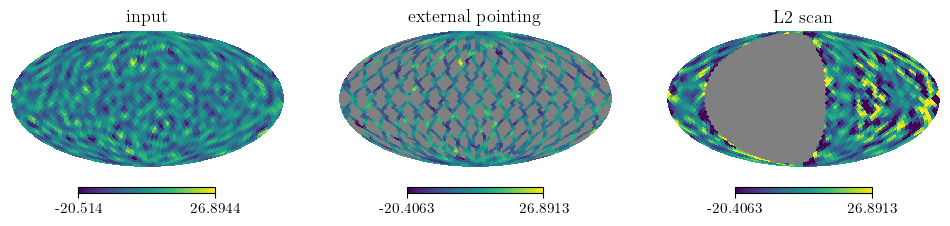

In [8]:
# plotting temperature maps
fwhm_rad = fwhm_arcmin/60/180*np.pi
smoothed_maps = hp.sphtfunc.smoothing(maps_16, fwhm=fwhm_rad)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(smoothed_maps[0], title=r'input', hold=True)
plt.axes(ax2)
hp.mollview(out_maps_ptg[0], title=r'external pointing', hold=True, min=Tmin, max=Tmax)
plt.axes(ax3)
hp.mollview(out_maps_L2[0], title=r'L2 scan', hold=True, min=Tmin, max=Tmax)
plt.show()

<b style="color:red;">The one with the external pointings looks better, but not really.</b>

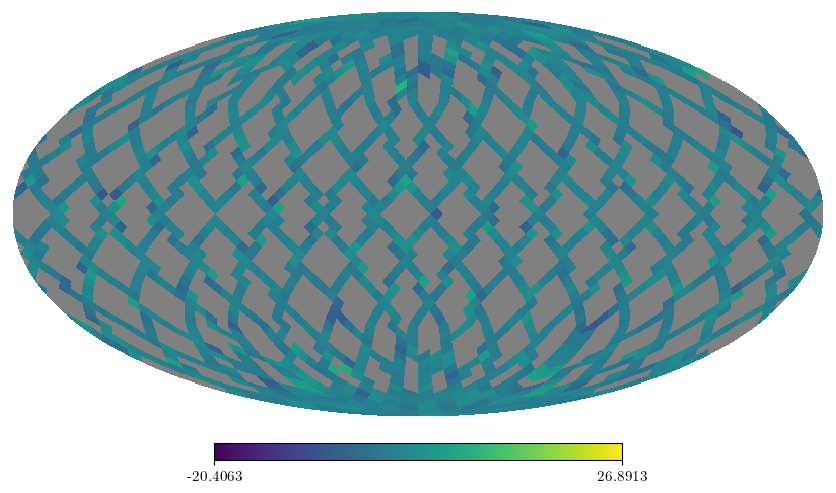

In [9]:
subtracted = np.where(out_maps_ptg[0]==hp.UNSEEN, hp.UNSEEN, out_maps_ptg[0]-smoothed_maps[0])
hp.mollview(subtracted, min=Tmin, max=Tmax, title=r'')

### Reading quaternions

Scanning with 4 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-8251200
Implementing L2 scan
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-8251200
Implementing L2 scan


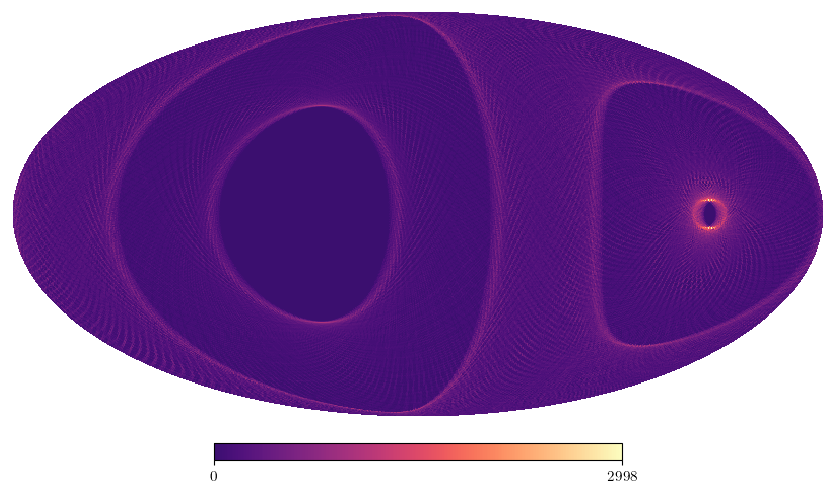

In [10]:
nside = 128 # had to define explicitly

ndet = 2
quats = np.zeros((2,2,4))
quats[0,0,:] = np.array([1.,0.,0.,0.])
quats[0,1,:] = np.array([0.009165646421980997, 0.09071095143135842, 0.0, 0.9958350838447524])
quats[1,0,:] = np.array([0.03704627596838304, 0.08283588163313664, 0.3811046277509462, 0.9200679609994841])
quats[1,1,:] = np.array([0.05236230340491963, 0.08463363396964103, 0.0, 0.9950353446904406])

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))

# setting up the beam options
beam_opts_quats = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm_arcmin,
                 quats=quats)

S_quats = ScanStrategy(duration=duration, sample_rate=fsamp)
S_quats.input_focal_plane(azs, els, polangs, combine=True, scatter=False, **beam_opts_quats)
S_quats.allocate_maps(nside=nside)
S_quats.scan_instrument_mpi(slm, save_tod=True, use_l2_scan=True, ctime0 = ctime0, 
                         ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_quats, cond, proj = S_quats.solve_for_map(return_proj = True)

hp.mollview(proj[0], cmap=new_cmap, title=r'')
plt.savefig('proj_quats.pdf')
del(S_quats, out_maps_quats, cond, proj)

In [11]:
quit()

### adding noise and dipole

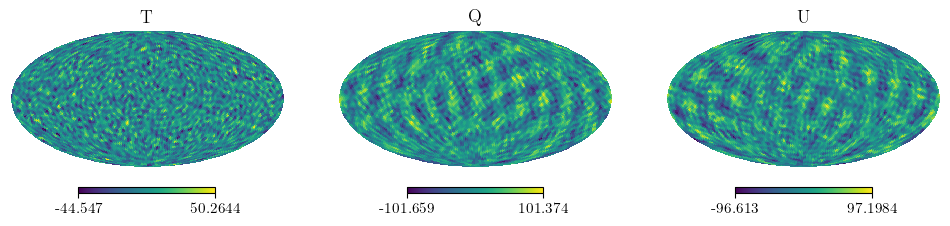

In [12]:
nside = 32
lmax = 2*nside

# generate input alm and maps
np.random.seed(10)
cls = np.random.rand(6,lmax)
cls[:,:2] *= 0
alm = hp.synalm(cls, lmax=lmax)
maps = hp.alm2map(alm,nside=nside)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps[0], title='T', hold=True)
plt.axes(ax2)
hp.mollview(maps[1], title='Q', hold=True)
plt.axes(ax3)
hp.mollview(maps[2], title='U', hold=True)
plt.show()

In [13]:
import ducc0

# parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
sigma = 10        
f_min = 1e-5
f_knee = 1e-3
slope = -1   
# Setting up and filling TOD (noise-only)
noise_TOD = np.empty((ndet,int(nsamp)))

gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, fsamp, slope)
inp = np.random.normal(0.,1.,(nsamp,))
noise_TOD = gen.filterGaussian(inp)

In [14]:
S_added = ScanStrategy(duration=duration, sample_rate=fsamp)
S_added.add_to_focal_plane(single_beam, combine=False)
S_added.allocate_maps(nside=nside)
S_added.scan_instrument_mpi(alm, save_tod=True, use_l2_scan=True, ctime0 = ctime0, 
                         ctime_kwargs=dict(), q_bore_kwargs=dict(),
                         add_to_tod = True, tod = noise_TOD)
out_maps, cond, proj = S_added.solve_for_map(return_proj = True)
hp.mollview(proj[0], cmap='magma', title='hitmap L2 scan')

Scanning with 1 detectors


KeyboardInterrupt: 

In [ ]:
hp.mollview(out_maps[0], title='hitmap L2 scan')

In [ ]:
from astropy.time import Time

# importing a slightly modified version of the spacecraft.py file
from spacecraft import SpacecraftOrbit
from spacecraft import spacecraft_pos_and_vel

# setting up the scanning strategy parameters
ctime0 = Time(ctime0, format="unix") #conversion to astropy object

orbit = SpacecraftOrbit(ctime0)

pos_vel = spacecraft_pos_and_vel(
            orbit,
            start_time=ctime0,
            time_span_s=duration,
            delta_time_s=1/19.
)

#pos_test = pos_vel.positions_km[:-1]
vel_test = pos_vel.velocities_km_s[:-1]

#print(pos_test)
from astropy.constants import c as c_light
from astropy.constants import h, k_B

C_LIGHT_KM_S = c_light.value / 1e3
H_OVER_K_B = h.value / k_B.value

def planck(nu_hz, t_k):
    """Return occupation number at frequency nu_hz and temperature t_k"""
    return 1 / (np.exp(H_OVER_K_B * nu_hz / t_k) - 1)

def compute_scalar_product(theta, phi, v):
    """Return the scalar (dot) product between a given direction and a velocity"""
    dx, dy, dz = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)

    return dx * v[0] + dy * v[1] + dz * v[2]

def calculate_beta(theta, phi, v_km_s):
    """Return a 2-tuple containing β·n and β"""
    beta_dot_n = compute_scalar_product(theta, phi, v_km_s) / C_LIGHT_KM_S
    beta = np.sqrt(v_km_s[0] ** 2 + v_km_s[1] ** 2 + v_km_s[2] ** 2) / C_LIGHT_KM_S

    return beta_dot_n, beta

# Full formula in linearized units (the most widely used):
def compute_dipole_for_one_sample_total_from_lin_t(
    theta, phi, v_km_s, t_cmb_k, nu_hz, f_x, planck_t0
):
    beta_dot_n, beta = calculate_beta(theta, phi, v_km_s)
    gamma = 1 / np.sqrt(1 - beta ** 2)

    planck_t = planck(nu_hz, t_cmb_k / gamma / (1 - beta_dot_n))

    return t_cmb_k / f_x * (planck_t / planck_t0 - 1)

def compute_dipole_for_one_chunk_total_from_lin_t(
    theta, phi, v_km_s, t_cmb_k, nu_hz, f_x, planck_t0
):
    dipole = np.empty(len(theta))
    for i in range(len(theta)):
        dipole[i] = compute_dipole_for_one_sample_total_from_lin_t(theta[i], phi[i], v_km_s[i], t_cmb_k, nu_hz, f_x, planck_t0)
    return dipole

t_cmb_k = 2.72548 # Fixsen 2009 http://arxiv.org/abs/0911.1955
nu_hz = 140*1e9
x = h.value * nu_hz / (k_B.value * t_cmb_k)
f_x = x * np.exp(x) / (np.exp(x) - 1)
planck_t0 = planck(nu_hz, t_cmb_k)
# Setting up and filling TOD (dipole-only) 
dipole_TOD = np.empty((ndet,nsamp))

for d in range(1):
    for chunk in range(1):
        pixels = S_added.data(chunks[chunk],ss.beams[d][0],data_type='pix')
        pointings = hp.pixelfunc.pix2ang(128, pixels)
        theta = pointings[0]
        phi = pointings[1]
        #
        vel_chunk = vel_test[chunk*nsamp_chunk:(chunk+1)*nsamp_chunk]
        dipole_TOD[d,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = compute_dipole_for_one_chunk_total_from_lin_t(theta,phi,vel_chunk,t_cmb_k,nu_hz,f_x,planck_t0)
    print(pixels)

In [ ]:
del(S_added)

In [ ]:
S_added = ScanStrategy(duration=duration, sample_rate=fsamp)
S_added.add_to_focal_plane(single_beam, combine=False)
S_added.allocate_maps(nside=nside)
S_added.scan_instrument_mpi(alm, save_tod=True, use_l2_scan=True, ctime0 = ctime0, 
                         ctime_kwargs=dict(), q_bore_kwargs=dict(),
                         add_to_tod = True, tod = dipole_TOD)
out_maps, cond, proj = S_added.solve_for_map(return_proj = True)
hp.mollview(out_maps[0], title='hitmap L2 scan')

In this script, we check that the TOD returned by beamconv overlaps with the analytical formula (no beam 
convolution)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [ ]:
nside = 16
npix = 12*nside**2
lmax = 2*nside
mmax = 2

pix = hp.ang2pix(nside, np.pi/2, 0) # pixel corresponding to a point on the equator
co_lat = hp.pix2ang(nside, pix)[0]  # co-latitude at the pixel's center
lon = hp.pix2ang(nside, pix)[1]     # longitude at the pixel's center

fwhm_arcmin = 5
fwhm_rad = fwhm_arcmin/60/180*np.pi
blm = hp.blm_gauss(fwhm_rad, lmax=lmax, pol = True)

In [ ]:
def fill_alm(alm, lmax, mmax):    
    # returns same as bml, but full alm_size
    alm_size = hp.Alm.getsize(lmax, mmax=mmax)
    alm_full = np.zeros((3,alm_size), dtype = np.complex128)

    idx_start = hp.Alm.getidx(lmax,0,0)
    idx_stop  = hp.Alm.getidx(lmax,lmax,0)
    alm_full[0,idx_start:idx_stop] = alm[0][idx_start:idx_stop]

    idx_start = hp.Alm.getidx(lmax,2,2)
    idx_stop = hp.Alm.getidx(lmax,lmax,2)
    alm_full[1,idx_start:idx_stop] = -alm[1][idx_start:idx_stop]
    alm_full[2,idx_start:idx_stop] = -alm[2][idx_start:idx_stop]
    
    return alm_full

bmap = hp.alm2map(fill_alm(blm,lmax=lmax,mmax=mmax),nside=nside,lmax=lmax,mmax=mmax)
norm = np.sum(bmap[0])

In [ ]:
def get_beamconv_values(lmax, fwhm_arcmin, slm, ptg, hwp_angles, mueller):
    from beamconv import Beam, ScanStrategy, tools
    import qpoint as qp

    # set up beam and HWP mueller matrix (identity, i.e. no HWP)
    beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)
    beam.hwp_mueller = mueller

    nsamp = ptg.shape[0]
    duration = 1        #scan duration in seconds
    sample_rate = nsamp #samples per second

    # from (theta,phi) to (ra,dec) convention
    # also, all angles are converted in degrees
    ra = np.degrees(ptg[:,1])
    dec = 90. - np.degrees(ptg[:,0])
    psi = np.degrees(ptg[:,2])

    # calculate the quaternion
    q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

    def ctime_test(**kwargs):
        start = kwargs.pop('start')
        end = kwargs.pop('end')
        nsamp = end - start
        ctime0 = 0
        ctime = ctime0 + sample_rate*np.arange(nsamp)
        return ctime
    
    def q_bore_test(**kwargs):
        start = kwargs.pop('start')
        end = kwargs.pop('end')
        return q_bore_array[start:end]
   
    S = ScanStrategy(duration=duration, sample_rate=sample_rate, external_pointing=True, use_l2_scan=False)
    S.add_to_focal_plane(beam, combine=False)
    S.set_hwp_mod(mode='stepped', freq=sample_rate, angles=hwp_angles*180/np.pi)
    S.allocate_maps(nside=nside)
    S.scan_instrument_mpi(slm, save_tod=True, ctime_func=ctime_test, q_bore_func=q_bore_test,
                      ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0})
    
    maps, cond, proj = S.solve_for_map(return_proj = True) 
    print(maps[:,pix])
    
    return S.data(S.chunks[0], beam=beam, data_type='tod').copy()

In [ ]:
# set up sky alm
np.random.seed(10)
cls = np.random.rand(4,lmax)
cls[:,:3] *= 0
print(np.shape(cls))
maps_pre = hp.synfast(cls, nside)

#maps_pre = np.ones((3,npix))

slm = hp.map2alm(maps_pre, lmax=lmax)
maps = hp.alm2map(slm,nside=nside)

mueller0 = np.diag([1.,1.,1.,1.])
mueller1 = np.diag([1.,1.,-1.,-1.])
mueller2 = np.asarray([[1, .1, 0, 0], [.1, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]], dtype=float)

nptg=1000
ptg = np.empty((nptg,3))
ptg[:,0] = co_lat         # theta
ptg[:,1] = lon            # phi
ptg[:,2] = np.zeros(nptg) # psi

pixs = hp.ang2pix(nside, ptg[:,0], ptg[:,1])

hwp_angles = (np.arange(nptg)+6)/nptg*8*np.pi  # alpha

tod0 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller0)
tod1 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller1)
tod2 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller2)

In [ ]:
plt.plot(tod0, label='no HWP', color='gray')
plt.plot(tod1, label='ideal', color='teal')
plt.plot(tod2, label='non-ideal', color='darkorange')
plt.title('beamconv')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
def rot_mat(theta):
    c, s = np.cos(2*theta), np.sin(2*theta)
    return np.array(((1,0,0),(0,c,s),(0,-s,c)))

In [ ]:
stokes = hp.sphtfunc.smoothing(maps, fwhm=fwhm_rad)[:,pixs[0]]

d0 = np.empty_like(tod0)
d1 = np.empty_like(tod1)
d2 = np.empty_like(tod2)

for i in np.arange(nptg):
    rot_mat_i = rot_mat(hwp_angles[i])
    stokes0 = rot_mat_i.transpose().dot(mueller0[:3,:3].dot(rot_mat_i).dot(stokes))
    d0[i] = (stokes0[0]+stokes0[1])
    stokes1 = rot_mat_i.transpose().dot(mueller1[:3,:3].dot(rot_mat_i).dot(stokes))
    d1[i] = (stokes1[0]+stokes1[1])
    stokes2 = rot_mat_i.transpose().dot(mueller2[:3,:3].dot(rot_mat_i).dot(stokes))
    d2[i] = (stokes2[0]+stokes2[1])

In [ ]:
plt.plot(d0, label='no HWP', color='gray')
plt.plot(d1, label='ideal', color='teal')
plt.plot(d2, label='non-ideal', color='darkorange')
plt.title('non-convolved')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
plt.plot(tod0, label='beamconv', color='gray')
plt.plot(d0, label='non-convolved', color='teal')
plt.title('no HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
plt.plot(tod1, label='beamconv', color='gray')
plt.plot(d1, label='non-convolved', color='teal')
plt.title('ideal HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
plt.plot(tod2, label='beamconv', color='gray')
plt.plot(d2, label='non-convolved', color='teal')
plt.title('non-ideal HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

# Trying to feed TOD to beamconv's map-maker

In [ ]:
from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

mueller=mueller2

# set up beam and HWP mueller matrix (identity, i.e. no HWP)
beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)
beam.hwp_mueller = mueller

nsamp = ptg.shape[0]
duration = 1       #scan duration in seconds
sample_rate = nsamp  #samples per second

ptg = np.empty((nptg,3))
ptg[:,0]=np.arange(nptg)*1e-2    # theta
ptg[:,1]=np.arange(nptg)*1e-2    # phi
ptg[:,2]=np.arange(nptg)*1e-2    # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
psi = np.degrees(ptg[:,2])

# calculate the quaternion
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def ctime_test(**kwargs):
    start = kwargs.pop('start')
    end = kwargs.pop('end')
    nsamp = end - start
    ctime0 = 0
    ctime = ctime0 + sample_rate*np.arange(nsamp)
    return ctime
    
def q_bore_test(**kwargs):
    start = kwargs.pop('start')
    end = kwargs.pop('end')
    return q_bore_array[start:end]
   
SS = ScanStrategy(duration=duration, sample_rate=sample_rate, external_pointing=True, use_l2_scan=False)
SS.add_to_focal_plane(beam, combine=False)
SS.set_hwp_mod(mode='stepped', freq=sample_rate, angles=hwp_angles*180/np.pi)
SS.allocate_maps(nside=nside)
SS.scan_instrument_mpi(slm, save_tod=False, ctime_func=ctime_test, q_bore_func=q_bore_test,
                  ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0})

np.random.seed(seed=10)
tod = np.random.rand(nsamp)

SS.bin_tod(SS.beams[0][0], tod=tod2, start=0, end=nsamp)
out_maps, cond, proj = SS.solve_for_map(return_proj = True)
print(out_maps[0,0])

In [ ]:
hp.mollview(maps[0])
hp.mollview(out_maps[0])